## Dependencias

####  scikit-learn: modelos, métricas, validação.
####  pandas: leitura dos CSVs.
####  joblib: salvar modelos treinados.
####  matplotlib: matriz de confusão.

In [1]:
%pip install -q scikit-learn pandas joblib matplotlib


[notice] A new release of pip is available: 25.0 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Imports e caminhos

In [4]:
from pathlib import Path
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score

# Pastas
DATA = Path("../data/processed")        # onde estão os CSVs traduzidos
ART  = Path("../model/artifacts")       # onde salvaremos os modelos
ART.mkdir(parents=True, exist_ok=True)

## Carregar dados (train/val/test)

In [5]:
train = pd.read_csv(DATA / "emotion_train_pt.csv")
val   = pd.read_csv(DATA / "emotion_val_pt.csv")
test  = pd.read_csv(DATA / "emotion_test_pt.csv")

# Garantir colunas esperadas
assert set(train.columns) == {"text","label"}
assert set(val.columns)   == {"text","label"}
assert set(test.columns)  == {"text","label"}

# Limpa NaNs e separa X,y
train = train.dropna(subset=["text","label"]).reset_index(drop=True)
val   = val.dropna(subset=["text","label"]).reset_index(drop=True)
test  = test.dropna(subset=["text","label"]).reset_index(drop=True)

X_train, y_train = train["text"], train["label"]
X_val,   y_val   = val["text"],   val["label"]
X_test,  y_test  = test["text"],  test["label"]

len(train), len(val), len(test)

(16000, 2000, 2000)

## Funções auxiliares (treino, avaliação, gráficos)

In [6]:
def evaluate(model, X, y, titulo=""):
    """Imprime F1-macro e relatório por classe."""
    pred = model.predict(X)
    print(f"\n== {titulo} ==")
    print("F1-macro:", f1_score(y, pred, average="macro"))
    print(classification_report(y, pred))
    return pred

def plot_confusion(y_true, y_pred, title="Matriz de confusão"):
    labels = sorted(np.unique(y_true))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=45, colorbar=False)
    plt.title(title)
    plt.tight_layout()
    plt.show()

## Pipelines base (TF-IDF + classificador)

In [7]:
# Vetorizador padrão para ambos os modelos
tfidf = TfidfVectorizer(
    max_features=30000,      # vocabulário de até 30k termos
    ngram_range=(1,2),       # unigrama + bigrama
    lowercase=True,          # normaliza
    strip_accents="unicode"  # remove acentuação
)

# Modelo 1: Logistic Regression (linear, com probabilidades)
pipe_logreg = Pipeline([
    ("tfidf", tfidf),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="saga",
        n_jobs=-1,
        random_state=42
    ))
])

# Modelo 2: SVM linear (LinearSVC) — rápido e forte para texto
pipe_svm = Pipeline([
    ("tfidf", tfidf),
    ("clf", LinearSVC(
        class_weight="balanced",
        random_state=42
    ))
])

## GridSearch (tunar cada modelo no train com CV e avaliar no val)

In [8]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Espaços de busca enxutos e eficientes
grid_logreg = {
    "tfidf__max_features": [20000, 30000, 50000],
    "clf__C": [0.5, 1.0, 2.0, 4.0],     # regularização (↑C = menos regularização)
    "clf__penalty": ["l2"],
}

grid_svm = {
    "tfidf__max_features": [20000, 30000, 50000],
    "clf__C": [0.5, 1.0, 2.0, 4.0],     # LinearSVC também usa C
}

# Treino + busca para LogReg
gs_logreg = GridSearchCV(
    pipe_logreg,
    grid_logreg,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=1
)
gs_logreg.fit(X_train, y_train)
best_logreg = gs_logreg.best_estimator_
print("LogReg - melhores params:", gs_logreg.best_params_)
print("LogReg - melhor F1 (CV):", gs_logreg.best_score_)

# Treino + busca para SVM
gs_svm = GridSearchCV(
    pipe_svm,
    grid_svm,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=1
)
gs_svm.fit(X_train, y_train)
best_svm = gs_svm.best_estimator_
print("SVM - melhores params:", gs_svm.best_params_)
print("SVM - melhor F1 (CV):", gs_svm.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/quelihesper/Portifolio-Python/moodflix/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/quelihesper/Portifolio-Python/moodflix/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/quelihesper/Portifolio-Python/moodflix/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/quelihesper/Portifolio-Python/moodflix/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/quelihesper/Portifolio-Python/moodflix/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: T

LogReg - melhores params: {'clf__C': 4.0, 'clf__penalty': 'l2', 'tfidf__max_features': 30000}
LogReg - melhor F1 (CV): 0.6028078247087308
Fitting 5 folds for each of 12 candidates, totalling 60 fits
SVM - melhores params: {'clf__C': 0.5, 'tfidf__max_features': 50000}
SVM - melhor F1 (CV): 0.6315705256429808


## Comparação no conjunto de validação

In [9]:
pred_val_log = evaluate(best_logreg, X_val, y_val, "VAL — LogisticRegression")
pred_val_svm = evaluate(best_svm,    X_val, y_val, "VAL — SVM (LinearSVC)")


== VAL — LogisticRegression ==
F1-macro: 0.6188650917487303
              precision    recall  f1-score   support

       anger       0.57      0.58      0.57       275
        fear       0.67      0.61      0.64       212
         joy       0.75      0.77      0.76       704
        love       0.51      0.55      0.53       178
     sadness       0.71      0.69      0.70       550
    surprise       0.56      0.47      0.51        81

    accuracy                           0.68      2000
   macro avg       0.63      0.61      0.62      2000
weighted avg       0.68      0.68      0.67      2000


== VAL — SVM (LinearSVC) ==
F1-macro: 0.6360532177397678
              precision    recall  f1-score   support

       anger       0.62      0.56      0.59       275
        fear       0.67      0.67      0.67       212
         joy       0.76      0.80      0.78       704
        love       0.56      0.53      0.54       178
     sadness       0.72      0.73      0.72       550
    surprise 

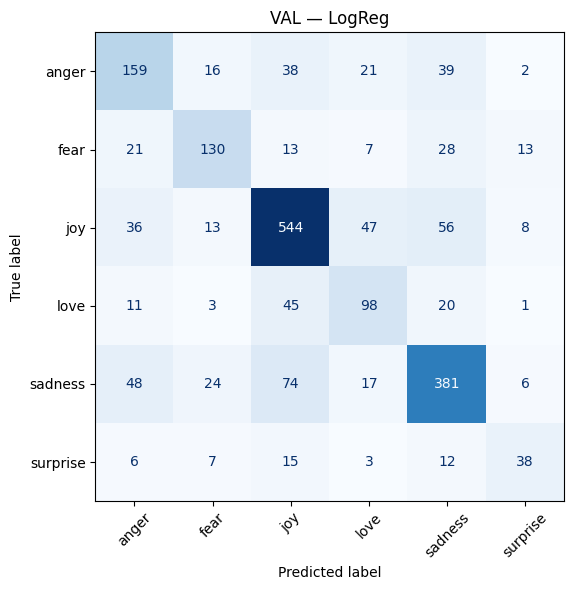

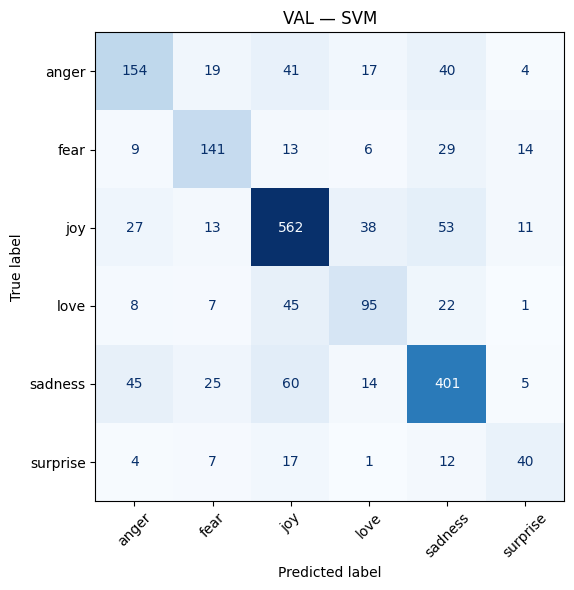

In [10]:
plot_confusion(y_val, pred_val_log, "VAL — LogReg")
plot_confusion(y_val, pred_val_svm, "VAL — SVM")

## Re-treinar o vencedor em train+val e avaliar no test

Vencedor no VAL: SVM

== TEST — SVM ==
F1-macro: 0.6375083268999185
              precision    recall  f1-score   support

       anger       0.63      0.60      0.62       275
        fear       0.72      0.69      0.70       224
         joy       0.76      0.79      0.78       695
        love       0.49      0.50      0.49       159
     sadness       0.75      0.71      0.73       581
    surprise       0.45      0.58      0.51        66

    accuracy                           0.70      2000
   macro avg       0.63      0.64      0.64      2000
weighted avg       0.70      0.70      0.70      2000



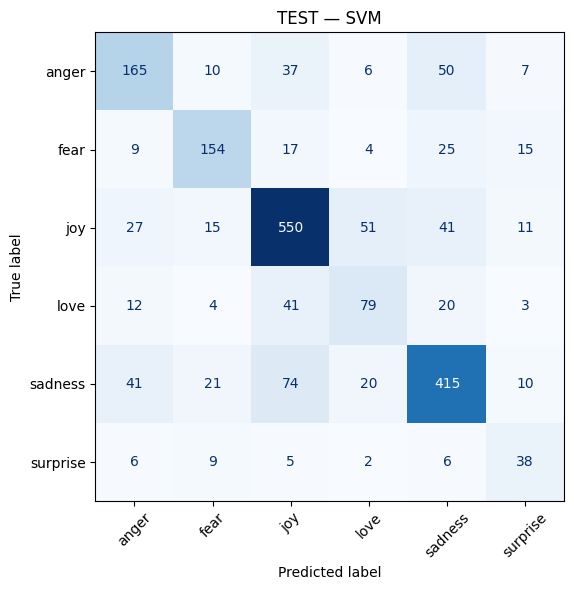

In [11]:
# Juntar train+val para extrair o máximo de dados antes do teste final
X_trval = pd.concat([X_train, X_val], axis=0)
y_trval = pd.concat([y_train, y_val], axis=0)

# Escolha o vencedor pelo desempenho no VAL:
winner_name, winner_pipe = (
    ("LogisticRegression", best_logreg)
    if f1_score(y_val, pred_val_log, average="macro") >= f1_score(y_val, pred_val_svm, average="macro")
    else ("SVM", best_svm)
)
print("Vencedor no VAL:", winner_name)

# Re-treinar do zero em train+val com os hiperparâmetros escolhidos
final_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=winner_pipe.named_steps["tfidf"].max_features,
        ngram_range=(1,2),
        lowercase=True,
        strip_accents="unicode"
    )),
    ("clf", type(winner_pipe.named_steps["clf"])(**{
        **{k: v for k, v in winner_pipe.named_steps["clf"].get_params().items()
           if k in type(winner_pipe.named_steps["clf"])( ).get_params()}
    }))
])

final_pipe.fit(X_trval, y_trval)

# Avaliar no TEST (uma única vez)
pred_test = evaluate(final_pipe, X_test, y_test, f"TEST — {winner_name}")
plot_confusion(y_test, pred_test, f"TEST — {winner_name}")

In [13]:
# top-50 erros do val para a classe 'love'
import numpy as np
pred = best_svm.predict(X_val)
mask = (y_val=="love") & (pred!="love")
X_val[mask].head(50).to_list()

['eu também achei que se poderia sentir o desesperança nessas sequências e eu particularmente gostei da emoção entre o cavaleiro e a squire como eles estiveram juntos de forma semelhante a batman e robin',
 'eu sinto como eu cuidar do meu corpo não só na tentativa de ser o tamanho certo, mas sentir-me bem e ter vida plena.',
 'eu sentava o frango preferencialmente ósseo em coxas de frango sem pele, pois eu sinto que eles têm o mais sabor em um pote de',
 'eu vejo o brilho de seu cabelo sem mais sentir a tenra kisses que usamos para dividir meus olhos e claro o meu coração lembram que mil bons olhos nunca conseguiram colocar os embriões.',
 'procuro compartilhar com muita gente porque eu amo as pessoas e quero que elas se sintam amadas.',
 'eu sinto um pouco de minha profundidade com minhas habilidades de cor entre todos esses talentos, mas por',
 'eu acho que eu tenho que sentir compassivo',
 'sinto tal gratidão pelos presentes generosos que recebemos no nosso dia de casamento ao longo

##  Salvar os dois modelos e o final

In [12]:
joblib.dump(best_logreg, ART / "emotion_logreg_val_best.joblib")
joblib.dump(best_svm,    ART / "emotion_svm_val_best.joblib")
joblib.dump(final_pipe,  ART / f"emotion_final_{winner_name.lower()}.joblib")

print("✔ salvos em:", ART.resolve())

✔ salvos em: /Users/quelihesper/Portifolio-Python/moodflix/model/artifacts


# Teste sem tradução

## Carregar os dados EN 

In [17]:
from pathlib import Path
import pandas as pd

RAW = Path("../data/raw")

def load_split_en(path: Path) -> pd.DataFrame:
    # tenta ; e depois \t
    try:
        df = pd.read_csv(path, sep=";", names=["text","label"], engine="python")
    except Exception:
        df = pd.read_csv(path, sep="\t", names=["text","label"], engine="python")
    df["text"]  = df["text"].astype(str).str.strip()
    df["label"] = df["label"].astype(str).str.strip()
    return df

train_en = load_split_en(RAW/"train.txt")
val_en   = load_split_en(RAW/"val.txt")
test_en  = load_split_en(RAW/"test.txt")

Xtr_en, ytr_en = train_en["text"], train_en["label"]
Xva_en, yva_en = val_en["text"],   val_en["label"]
Xte_en, yte_en = test_en["text"],  test_en["label"]

len(train_en), len(val_en), len(test_en), train_en.head(3)

(16000,
 2000,
 2000,
                                                 text    label
 0                            i didnt feel humiliated  sadness
 1  i can go from feeling so hopeless to so damned...  sadness
 2   im grabbing a minute to post i feel greedy wrong    anger)

## reinar LogReg e SVM (mesma receita, só que em EN)

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, classification_report
import joblib

tfidf_en = TfidfVectorizer(
    max_features=30000, ngram_range=(1,2),
    lowercase=True, strip_accents="unicode",
    sublinear_tf=True
)

pipe_log_en = Pipeline([
    ("tfidf", tfidf_en),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", solver="saga", n_jobs=-1, random_state=42))
])

pipe_svm_en = Pipeline([
    ("tfidf", tfidf_en),
    ("clf", LinearSVC(class_weight="balanced", random_state=42))
])

param_grid_log = {
    "tfidf__max_features": [20000, 30000, 50000],
    "clf__C": [0.5, 1.0, 2.0, 4.0],
}
param_grid_svm = {
    "tfidf__max_features": [20000, 30000, 50000],
    "clf__C": [0.5, 1.0, 2.0, 4.0],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gs_log_en = GridSearchCV(pipe_log_en, param_grid_log, scoring="f1_macro", cv=cv, n_jobs=-1, verbose=1)
gs_log_en.fit(Xtr_en, ytr_en)

gs_svm_en = GridSearchCV(pipe_svm_en, param_grid_svm, scoring="f1_macro", cv=cv, n_jobs=-1, verbose=1)
gs_svm_en.fit(Xtr_en, ytr_en)

best_log_en = gs_log_en.best_estimator_
best_svm_en = gs_svm_en.best_estimator_

print("EN LogReg CV:", gs_log_en.best_score_, gs_log_en.best_params_)
print("EN SVM    CV:", gs_svm_en.best_score_, gs_svm_en.best_params_)

# avaliação em VAL e TEST (EN)
def eval_set(model, X, y, name):
    pred = model.predict(X)
    print(f"\n{name} F1-macro:", f1_score(y, pred, average="macro"))
    print(classification_report(y, pred))
    return pred

pred_val_log_en = eval_set(best_log_en, Xva_en, yva_en, "VAL EN LogReg")
pred_val_svm_en = eval_set(best_svm_en, Xva_en, yva_en, "VAL EN SVM")

pred_test_log_en = eval_set(best_log_en, Xte_en, yte_en, "TEST EN LogReg")
pred_test_svm_en = eval_set(best_svm_en, Xte_en, yte_en, "TEST EN SVM")

# salve artefatos EN para comparação
ART = Path("../model/artifacts"); ART.mkdir(parents=True, exist_ok=True)
joblib.dump(best_log_en, ART/"emotion_logreg_en_val_best.joblib")
joblib.dump(best_svm_en, ART/"emotion_svm_en_val_best.joblib")

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/quelihesper/Portifolio-Python/moodflix/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/quelihesper/Portifolio-Python/moodflix/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/quelihesper/Portifolio-Python/moodflix/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/quelihesper/Portifolio-Python/moodflix/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/quelihesper/Portifolio-Python/moodflix/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: T

Fitting 5 folds for each of 12 candidates, totalling 60 fits
EN LogReg CV: 0.8483677986373068 {'clf__C': 4.0, 'tfidf__max_features': 20000}
EN SVM    CV: 0.858556755701071 {'clf__C': 0.5, 'tfidf__max_features': 20000}

VAL EN LogReg F1-macro: 0.8647950208288672
              precision    recall  f1-score   support

       anger       0.91      0.91      0.91       275
        fear       0.88      0.82      0.85       212
         joy       0.93      0.91      0.92       704
        love       0.80      0.90      0.84       178
     sadness       0.92      0.92      0.92       550
    surprise       0.73      0.79      0.76        81

    accuracy                           0.90      2000
   macro avg       0.86      0.87      0.86      2000
weighted avg       0.90      0.90      0.90      2000


VAL EN SVM F1-macro: 0.8851807796615093
              precision    recall  f1-score   support

       anger       0.92      0.92      0.92       275
        fear       0.89      0.85      0.87  

['../model/artifacts/emotion_svm_en_val_best.joblib']

## Comparar A (PT) vs B (EN)

In [19]:
import pandas as pd
from sklearn.metrics import f1_score

rows = []
# preencha com F1-macro VAL/TEST dos seus modelos PT
f1_pt_svm_val = 0.6360532177397678
f1_pt_svm_test = 0.6375083268999185



f1_en_svm_val   = f1_score(yva_en, pred_val_svm_en, average="macro")
f1_en_svm_test  = f1_score(yte_en, pred_test_svm_en, average="macro")



cmp = pd.DataFrame({
    "Modelo": ["SVM"],
    "VAL_PT":  [f1_pt_svm_val],
    "VAL_EN":  [f1_en_svm_val],
    "TEST_PT": [f1_pt_svm_test],
    "TEST_EN": [f1_en_svm_test],
})
cmp

,Modelo,VAL_PT,VAL_EN,TEST_PT,TEST_EN
0,SVM,0.636053,0.885181,0.637508,0.84635
